<a href="https://colab.research.google.com/github/castlechoi/studyingDL/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load MNIST Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

## Model

In [ ]:
class Generator(nn.Module):
  def __init__(self,latent_dim):
    super(Generator, self).__init__()
    self.input_dim = 128
    self.output_dim = 28 * 28 * 1

    self.model = nn.Sequential(
        nn.Linear(latent_dim,self.input_dim),
        nn.BatchNorm1d(128,0.8),
        nn.ReLU(),

        nn.Linear(self.input_dim, self.input_dim * 2),
        nn.BatchNorm1d(self.input_dim * 2, 0.8),
        nn.ReLU(),

        nn.Linear(self.input_dim * 2, self.input_dim * 4),
        nn.BatchNorm1d(self.input_dim * 4, 0.8),
        nn.ReLU(),

        nn.Linear(self.input_dim*4, self.output_dim),
        nn.Tanh()
    )

  def forward(self, x):
    fake = self.model(x)
    fake = fake.view(fake.size(0),1,28,28) # batch * channel * w * h
    return fake

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1* 28 * 28, 512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self, img):
    flatten = img.view(img.size(0), -1)
    out = self.model(flatten)
    return out

## Train

In [ ]:
latent_dim = 100
lr = 0.0002
betas = (0.5, 0.99)

n_epochs = 200
sample_interval = 2000

In [ ]:
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss().cuda()

optimizer_g = optim.Adam(generator.parameters(), lr = lr, betas=betas)
optimizer_d = optim.Adam(discriminator.parameters(), lr = lr, betas=betas)

In [ ]:
import time
from tqdm import tqdm

start_time = time.time()

for epoch in tqdm(range(n_epochs)):
  for i, (img, _) in enumerate(dataloader):
    # batch size 만큼 label 생성
    real = torch.FloatTensor(img.size(0),1).fill_(1.0).cuda() 
    fake = torch.FloatTensor(img.size(0),1).fill_(0.0).cuda()

    # noise 생성
    z = torch.normal(mean = 0, std = 1, size = (img.size(0), 100)).cuda()

    real_imgs = img.cuda()

    optimizer_g.zero_grad()
    optimizer_d.zero_grad()

    generated_imgs = generator(z)
    # generator generate image
    g_loss = criterion(discriminator(generated_imgs), real)
    g_loss.backward()
    optimizer_g.step()

    
    real_loss = criterion(discriminator(real_imgs), real)
    fake_loss = criterion(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_d.step()

    done = epoch * len(dataloader) + i
    if done % sample_interval == 0:
      save_image(generated_imgs.data[:25], f"{done}.png", nrow = 5, normalize = True )
 # 하나의 epoch이 끝날 때마다 로그(log) 출력
  # print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")     

  1%|          | 2/200 [00:40<1:06:17, 20.09s/it]


KeyboardInterrupt: ignored

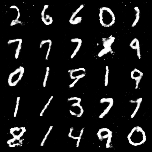

In [ ]:
from IPython.display import Image

Image('92000.png')